# Training an Object Detection Model

## 🌟 Overview
In this tutorial we'll go through the process of training a custom object detection model. We'll first create a dataset, setup the training configuration and then use it to train our own NN model. We'll also validate the performance of our model, export it and make it ready for a deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️-installation)
- [🗃️ Data Preparation](#️-data-preparation)
    - [🧐 Parsing the Data](#-parsing-the-data)
    - [💾 LuxonisDataset](#-luxonisdataset)
- [🏋️‍♂️ Training](#️️-training)
    - [⚙️ Configuration](#️-configuration)
    - [🦾 Train](#-train)
- [✍ Test](#-test)
    - [🧠 Infer](#-infer)
- [🗂️ Export and Archive](#️-export-and-archive)
- [🤖 Deploy](#-deploy)
- [📷 DepthAI Script](#-depthai-script)


## 🛠️ Installation

The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train) which is a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality and an easy way of creating and managing computer vision datasets callend `LuxonisDatasetFormat`. And lastly we'll download [`Kaggle`](https://www.kaggle.com/) package, which is where our data will come from.

In [1]:
%pip install luxonis-train kaggle

Note: you may need to restart the kernel to use updated packages.


## 🗃️ Data Preparation

First we need to download and prepare our dataset. For this example we'll use a publicly available dataset from Kaggle called [`Fruit Images for Object Detection`](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection). Our task is to train a model that is able to detect apples, bananas and oranges. 

To download the dataset we'll run this:

In [5]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
 99%|█████████████████████████████████████▌| 28.0M/28.4M [00:04<00:00, 6.54MB/s]
100%|██████████████████████████████████████| 28.4M/28.4M [00:04<00:00, 6.77MB/s]


### 🧐 Parsing the Data

Before we create a dataset it is advised we first look into the data and inspect what we have. In our case we have `train` and `test` folders that have images and their respective annotations in xml format. To make sure we understand how to parse this data we'll first write a simple script that takes one image and visualizes the labels on to it.

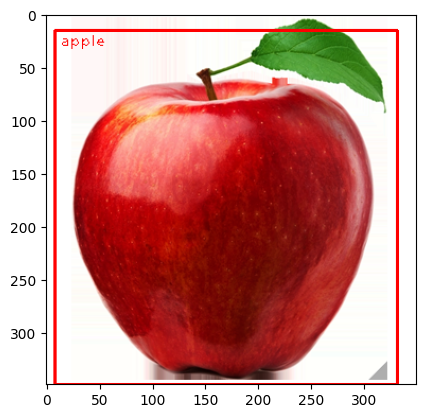

In [2]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

IMG_PATH = "./data/train_zip/train/apple_1.jpg"
ANN_PATH = "./data/train_zip/train/apple_1.xml"

def xml_find(root: ET.Element, tag: str) -> str:
    item = root.find(tag)
    if item is not None and item.text is not None:
        return item.text
    raise ValueError(f"Could not find {tag} in {root}")


img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annotation_data = ET.parse(ANN_PATH)
root = annotation_data.getroot()
for object_item in root.findall("object"):
    class_name = xml_find(object_item, "name")
    bbox_info = object_item.find("bndbox")

    bbox_xyxy = [
        int(xml_find(bbox_info, "xmin")),
        int(xml_find(bbox_info, "ymin")),
        int(xml_find(bbox_info, "xmax")),
        int(xml_find(bbox_info, "ymax"))
    ]
    img = cv2.rectangle(img, bbox_xyxy[:2], bbox_xyxy[2:], 255, 2)
    img = cv2.putText(img, class_name, (bbox_xyxy[0]+5, bbox_xyxy[1]+15), 1, 1, 255, 1)

plt.imshow(img)
plt.show()

### 💾 LuxonisDataset

Now that we are fimilar with the data we can start creating a `LuxonisDataset`. First we need to create a dataset instance which we'll call `fruit_dataset`.

In [3]:
from luxonis_ml.data import LuxonisDataset

dataset = LuxonisDataset(dataset_name="fruit_dataset", delete_existing=True) # if dataset with this name already exists then we delete the old instance

To add data to LuxonisDataset you need to create a generator function which yields annotations in the correct format. For object detection the annotations should be in `[x_min, y_min, width, height] normalized format` which means all values should be normalized between [0,1]. As mentioned before we have `train` and `test` subsets already created by the data providers but we also want to have a `val` subset that is used to monitor our training run. In order to make it, we'll use 20% of the training subset for validation. 

Let's now first create a function called `process_dir` which will get a path to the directory and return generator function of type DatasetIterator and a list of paths of added images.

In [4]:
from luxonis_ml.data import DatasetIterator
from pathlib import Path
import numpy as np

def process_dir(dir_path: Path) -> tuple[DatasetIterator, list[str]]:
    images = [str(i.absolute().resolve()) for i in dir_path.glob("*.jpg")]
    
    def generator() -> DatasetIterator:
        for img_path in images:
            ann_path = Path(img_path).with_suffix(".xml")
            annotation_data = ET.parse(ann_path)
            root = annotation_data.getroot()
            
            height, width, _ = cv2.imread(img_path).shape
            
            for object_item in root.findall("object"):
                class_name = xml_find(object_item, "name")

                bbox_info = object_item.find("bndbox")
                if bbox_info is not None:
                    bbox_xywh = np.array(
                        [
                            float(xml_find(bbox_info, "xmin")),
                            float(xml_find(bbox_info, "ymin")),
                            float(xml_find(bbox_info, "xmax"))
                            - float(xml_find(bbox_info, "xmin")),
                            float(xml_find(bbox_info, "ymax"))
                            - float(xml_find(bbox_info, "ymin")),
                        ]
                    )
                    bbox_xywh[::2] /= width
                    bbox_xywh[1::2] /= height

                    yield {
                        "file": img_path,
                        "annotation": {
                            "type": "boundingbox",
                            "class": class_name,
                            "x": bbox_xywh[0],
                            "y": bbox_xywh[1],
                            "w": bbox_xywh[2],
                            "h": bbox_xywh[3]
                        }
                    }
    
    return generator(), images

We can now use this function to process both train and test directories and add them to our LuxonisDataset instance. 

In [5]:
train_dir_path = Path("data/train_zip/train")
train_gen, train_images = process_dir(dir_path=train_dir_path)

test_dir_path = Path("data/test_zip/test")
test_gen, test_images = process_dir(dir_path=test_dir_path)

# Add data to the dataset
dataset = dataset.add(train_gen)
dataset = dataset.add(test_gen)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


/home/klemen/luxonis/depthai-ml-training/tutorial_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

libpng warning: iCCP: known incorrect sRGB profile


Last step is to split the data into `train`, `val` and `test` subsets. And as mentioned before we'll use 20% of the training data as validation since this is not already present in the original data.

In [6]:
from random import shuffle

shuffle(train_images) # shuffle the images
split_idx = int(len(train_images) * 0.8)
actual_train_images = train_images[:split_idx]
actual_val_images = train_images[split_idx:]

dataset.make_splits(
    splits={
        "train": actual_train_images,
        "val": actual_val_images,
        "test": test_images
    }
)

To varify that the data is correctly loaded and split into subsets we can check the dataset's information and visualizations of the annotations.

In [7]:
!luxonis_ml data info fruit_dataset

╭───────────── Dataset Info ──────────────╮
│ Name: fruit_dataset                     │
│                                         │
│ ╭─ Split Sizes ─╮                       │
│ │ train: 192    │                       │
│ │ val: 48       │                       │
│ │ test: 60      │                       │
│ │ ───────────── │                       │
│ │ Total: 300    │                       │
│ ╰───────────────╯                       │
│                 Classes                 │
│ ╭─────────────┬───────────────────────╮ │
│ │ Task        │ Class Names           │ │
│ ├─────────────┼───────────────────────┤ │
│ │ boundingbox │ apple, orange, banana │ │
│ ╰─────────────┴───────────────────────╯ │
╰─────────────────────────────────────────╯


In [61]:
!luxonis_ml data inspect fruit_dataset # NOTE: If you are on Google Colab this command will not work

## 🏋️‍♂️ Training

### ⚙️ Configuration

We have the dataset prepared and now we are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you that you take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task and then edit you to fit your needs.

In our case we are training an object detection and thus we'll take a [`detection_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/detection_light_model.yaml) as a starting point. There is a lot of parameters that we can change and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial we'll only go through some of the basic ones to get you started on your journey.

#### Model
In this section you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a complitely custom neural network by connection different nodes, losses, metrics and visualizers together. We'll go with the predefined `DetectionModel`.

#### Loader
This section of the config referes to the data loading. You can either setup your custom Loader or just use the default one with the LuxonisDataset. In our case we'll go with the seconf option and all we need to do is to set `dataset_name` to `fruit_dataset`

#### Trainer
In this section we can set up everything connected to actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers and many more. For full list please refer to the [full documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

**Augmentations**
In our case we'll leave most of the things as they are, the only change will be adding some augmentations. We use [`Albumentations`](https://albumentations.ai/) for our augmentations with additional of some custom ones like Mosaic4 and MixUp. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your specific training run. We can add some Affine transforms, For this specific training run we'll add some Affine transforms, HorizontalFlip and ColorJitter but feel free to edit this.

**Callbacks**
Callbacks are very helpful when we want to merge more functionalities into a single training run. For example, we want to first train the model then evaluate it on test subset, export it and create an archive. All of these steps can be defined through the config and done by a single call. For the purpose of a nicer explanation we won't be using them in this tutorial but feel free to set them up on your own. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks)

Below is a starting point for your config. As mentioned we already made some changes to it so it works with this tutorial (change of model name, dataset name and addition of augmentations) but feel free to edit it further and make it your own. When you are done editing you can just execute the cell and the file will be written and ready to use.

**Note**: In case you don't have enough compute on your machine you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled) or you can try lowering number of epochs and/or batch size but in that case performance might drop.

In [68]:
%%writefile fruit_detection_config.yaml
model:
  name: fruit_detection_model
  predefined_model:
    name: DetectionModel
    params:
      variant: light

loader:
  params:
    dataset_name: fruit_dataset

trainer:
  preprocessing:
    train_image_size: [384, 512]
    keep_aspect_ratio: true
    normalize:
      active: true

    augmentations:
      - name: Affine
        params:
          scale: [0.7, 1.7]
          rotate: 20
          shear: 5
          p: 0.3
      - name: HorizontalFlip
        params:
          p: 0.3
      - name: ColorJitter
        params:
          brightness: [0.8, 1.2]
          contrast: [0.8, 1.2]
          saturation: [0.8, 1.2]
          hue: 0
          p: 0.2

  batch_size: 8
  epochs: &epochs 200
  n_workers: 8
  validation_interval: 10
  n_log_images: 8

  optimizer:
    name: SGD
    params:
      lr: 0.02
      momentum: 0.937
      weight_decay: 0.0005
      dampening: 0.0
      nesterov: true

  scheduler:
    name: CosineAnnealingLR
    params:
      T_max: *epochs
      eta_min: 0.0002
      last_epoch: -1

Overwriting fruit_detection_config.yaml


### 🦾 Train

To start the training we just need to initialize the `LuxonisModel`, pass it the path to the configuration file and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes but when you do it yourself feel free to use them.

In [69]:
from luxonis_train import LuxonisModel

config_path = "fruit_detection_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

INFO     Using predefined model: `DetectionModel`                                                     ]8;id=936591;file:///home/klemen/luxonis/luxonis-train/luxonis_train/config/config.py\config.py]8;;\:]8;id=464143;file:///home/klemen/luxonis/luxonis-train/luxonis_train/config/config.py#131\131]8;;\

INFO     Main metric: `MeanAveragePrecision`                                                          ]8;id=755922;file:///home/klemen/luxonis/luxonis-train/luxonis_train/config/config.py\config.py]8;;\:]8;id=55480;file:///home/klemen/luxonis/luxonis-train/luxonis_train/config/config.py#154\154]8;;\

INFO     GPU available: True (cuda), used: True                                                     ]8;id=126039;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=830880;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=590430;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=204464;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=97497;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=344995;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO     Train loader - splits: ['train'], size: 192                                                    ]8;id=676833;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=775787;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#156\156]8;;\

INFO     Val loader - splits: ['val'], size: 48                                                         ]8;id=21770;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=156142;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#156\156]8;;\

INFO     Test loader - splits: ['test'], size: 60                                                       ]8;id=785666;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=582462;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#156\156]8;;\

INFO     Checkpoints will be saved in: output/1-fuchsia-jaguar                                          ]8;id=294589;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=494107;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#257\257]8;;\

INFO     Starting training...                                                                           ]8;id=270537;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=924801;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#258\258]8;;\

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=366985;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=662922;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                       ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nodes                      │ ModuleDict        │  4.7 M │ train │
│ 1 │ nodes.detection_backbone   │ EfficientRep      │  3.1 M │ train │
│ 2 │ nodes.detection_neck       │ RepPANNeck        │  1.2 M │ train │
│ 3 │ nodes.detection_head       │ EfficientBBoxHead │  411 K │ train │
│ 4 │ losses                     │ ModuleDict        │  411 K │ train │
│ 5 │ losses.detection_head      │ ModuleDict        │  411 K │ train │
│ 6 │ metrics                    │ ModuleDict        │  411 K │ train │
│ 7 │ metrics.detection_head     │ ModuleDict        │  411 K │ train │
│ 8 │ visualizers                │ ModuleDict        │  411 K │ train │
│ 9 │ visualizers.detection_head │ ModuleDict        │  411 K │ train │
└───┴────────────────────────────┴───────────────────┴────────┴───────┘

Trainable params: 4.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 537                                                                                         
Modules in eval mode: 0

WARNING  /home/klemen/envs/luxonis/lib/python3.10/site-packages/rich/live.py:231: UserWarning:       ]8;id=343221;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=391247;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py#121\121]8;;\
         install "ipywidgets" for Jupyter support                                                                  
           warnings.warn('install "ipywidgets" for Jupyter support')                                               
                                                                                                                   

INFO     Switching to Task Aligned Assigner after 0 warmup epochs.                   ]8;id=540500;file:///home/klemen/luxonis/luxonis-train/luxonis_train/attached_modules/losses/adaptive_detection_loss.py\adaptive_detection_loss.py]8;;\:]8;id=423091;file:///home/klemen/luxonis/luxonis-train/luxonis_train/attached_modules/losses/adaptive_detection_loss.py#209\209]8;;\

WARNING  /home/klemen/envs/luxonis/lib/python3.10/site-packages/torchvision/utils.py:211:            ]8;id=895806;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=62834;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py#121\121]8;;\
         UserWarning: boxes doesn't contain any box. No box was drawn                                              
           warnings.warn("boxes doesn't contain any box. No box was drawn")                                        
                                                                                                                   

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=169941;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=238795;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=804068;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=414427;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 2.7598                                                           ]8;id=897996;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=698961;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 2.7597849369049072

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.00000  │
│ map_50        │ 0.00000  │
│ map_75        │ 0.00000  │
│ map_small     │ -1.00000 │
│ map_medium    │ -1.00000 │
│ map_large     │ 0.00000  │
│ mar_1         │ 0.00000  │
│ mar_10        │ 0.00000  │
│ mar_100       │ 0.00000  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ -1.00000 │
│ mar_large     │ 0.00000  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ -1.00000 │
│ f1_large      │ nan      │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.0000                     ]8;id=291048;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=358798;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

WARNING  /home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py: ]8;id=343221;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=391247;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py#121\121]8;;\
         298: The number of training batches (24) is smaller than the logging interval                             
         Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see                 
         logs for the training epoch.                                                                              
                                                                                                                   

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=540500;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=423091;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=895806;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=62834;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.9817                                                           ]8;id=169941;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=238795;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.9817423224449158

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.01352  │
│ map_50        │ 0.05655  │
│ map_75        │ 0.00290  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.01394  │
│ mar_1         │ 0.04500  │
│ mar_10        │ 0.05357  │
│ mar_100       │ 0.05357  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.05549  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.02229  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.0135                     ]8;id=804068;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=414427;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=897996;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=698961;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=291048;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=358798;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.8111                                                           ]8;id=113935;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=854145;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.811083734035492

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.12047  │
│ map_50        │ 0.27009  │
│ map_75        │ 0.09577  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.12992  │
│ mar_1         │ 0.14570  │
│ mar_10        │ 0.19365  │
│ mar_100       │ 0.19365  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.20868  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.16014  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1205                     ]8;id=346802;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=308160;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=972474;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=373101;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=192752;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=344458;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.7555                                                           ]8;id=923238;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=107263;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.7555031975110371

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.14980  │
│ map_50        │ 0.38456  │
│ map_75        │ 0.07869  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.16100  │
│ mar_1         │ 0.19273  │
│ mar_10        │ 0.25395  │
│ mar_100       │ 0.25395  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.27458  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.20298  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1498                     ]8;id=510886;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=840986;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=381606;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=496845;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=173887;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=348413;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.6920                                                           ]8;id=45807;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=143710;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.6919527649879456

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.19730  │
│ map_50        │ 0.42760  │
│ map_75        │ 0.13573  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.21331  │
│ mar_1         │ 0.19173  │
│ mar_10        │ 0.29159  │
│ mar_100       │ 0.29159  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.31597  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.25468  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.1973                     ]8;id=35113;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=478944;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=557877;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=338273;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=895179;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=589465;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.6896                                                           ]8;id=900581;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=663284;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.6895812153816223

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.20915  │
│ map_50        │ 0.49184  │
│ map_75        │ 0.11970  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.00000  │
│ map_large     │ 0.22525  │
│ mar_1         │ 0.22391  │
│ mar_10        │ 0.30974  │
│ mar_100       │ 0.30974  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.00000  │
│ mar_large     │ 0.33337  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ nan      │
│ f1_large      │ 0.26885  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2092                     ]8;id=995485;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=55457;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=776502;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=534123;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=87985;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=185696;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.6631                                                           ]8;id=234264;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=258490;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.6631345947583516

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.24216  │
│ map_50        │ 0.51871  │
│ map_75        │ 0.23415  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.15099  │
│ map_large     │ 0.25547  │
│ mar_1         │ 0.24356  │
│ mar_10        │ 0.34492  │
│ mar_100       │ 0.34492  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.15000  │
│ mar_large     │ 0.36267  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.15049  │
│ f1_large      │ 0.29978  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2422                     ]8;id=416767;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=317739;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=980741;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=673981;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=648282;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=892856;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.6541                                                           ]8;id=271245;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=932804;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.654067615667979

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.25430  │
│ map_50        │ 0.50395  │
│ map_75        │ 0.25367  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.17574  │
│ map_large     │ 0.26965  │
│ mar_1         │ 0.25567  │
│ mar_10        │ 0.33328  │
│ mar_100       │ 0.33328  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.17500  │
│ mar_large     │ 0.35070  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.17537  │
│ f1_large      │ 0.30488  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2543                     ]8;id=481766;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=736667;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=742240;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=345463;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=240187;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=926580;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5932                                                           ]8;id=566968;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=840420;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.5932127038637798

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.28190  │
│ map_50        │ 0.54175  │
│ map_75        │ 0.29591  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.10050  │
│ map_large     │ 0.30037  │
│ mar_1         │ 0.27782  │
│ mar_10        │ 0.37034  │
│ mar_100       │ 0.37034  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.10000  │
│ mar_large     │ 0.39348  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.10025  │
│ f1_large      │ 0.34068  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2819                     ]8;id=465145;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=443334;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=145076;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=93645;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=313089;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=389416;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5835                                                           ]8;id=731864;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=451150;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.583452006181081

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.29452  │
│ map_50        │ 0.57223  │
│ map_75        │ 0.24686  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.02525  │
│ map_large     │ 0.31608  │
│ mar_1         │ 0.28166  │
│ mar_10        │ 0.35415  │
│ mar_100       │ 0.35415  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.02500  │
│ mar_large     │ 0.38114  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.02512  │
│ f1_large      │ 0.34557  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2945                     ]8;id=893305;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=67394;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=326189;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=797488;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=641926;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=964248;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5140                                                           ]8;id=330362;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=179464;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.514047344525655

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.31032  │
│ map_50        │ 0.58520  │
│ map_75        │ 0.29600  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.07574  │
│ map_large     │ 0.33171  │
│ mar_1         │ 0.29672  │
│ mar_10        │ 0.36727  │
│ mar_100       │ 0.36727  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.07500  │
│ mar_large     │ 0.39370  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.07537  │
│ f1_large      │ 0.36006  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3103                     ]8;id=457482;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=690985;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=824285;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=39009;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=967603;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=43403;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5454                                                           ]8;id=941910;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=978940;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.545415222644806

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.31152  │
│ map_50        │ 0.57303  │
│ map_75        │ 0.27960  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.10099  │
│ map_large     │ 0.33270  │
│ mar_1         │ 0.29447  │
│ mar_10        │ 0.36794  │
│ mar_100       │ 0.36794  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.10000  │
│ mar_large     │ 0.39377  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.10049  │
│ f1_large      │ 0.36067  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3115                     ]8;id=468886;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=926881;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=180876;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=268034;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=317988;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=37540;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5655                                                           ]8;id=214743;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=808944;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.565459132194519

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.29256  │
│ map_50        │ 0.57683  │
│ map_75        │ 0.27229  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.12624  │
│ map_large     │ 0.31063  │
│ mar_1         │ 0.28360  │
│ mar_10        │ 0.35970  │
│ mar_100       │ 0.35970  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.12500  │
│ mar_large     │ 0.38212  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.12562  │
│ f1_large      │ 0.34269  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.2926                     ]8;id=214123;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=291453;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=634293;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=765278;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=478220;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=122409;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.5355                                                           ]8;id=414999;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=299178;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.5354879299799602

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.32265  │
│ map_50        │ 0.55454  │
│ map_75        │ 0.36932  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.12624  │
│ map_large     │ 0.34353  │
│ mar_1         │ 0.30451  │
│ mar_10        │ 0.38806  │
│ mar_100       │ 0.38806  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.12500  │
│ mar_large     │ 0.41286  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.12562  │
│ f1_large      │ 0.37502  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3227                     ]8;id=101462;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=631648;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=607372;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=493307;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=739336;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=889533;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4767                                                           ]8;id=694238;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=854205;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4767261147499084

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.35183  │
│ map_50        │ 0.60020  │
│ map_75        │ 0.38340  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.17673  │
│ map_large     │ 0.37177  │
│ mar_1         │ 0.31485  │
│ mar_10        │ 0.41599  │
│ mar_100       │ 0.41599  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.17500  │
│ mar_large     │ 0.44037  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.17586  │
│ f1_large      │ 0.40317  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3518                     ]8;id=832851;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=807501;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=760602;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=966078;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=150132;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=809515;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4989                                                           ]8;id=227553;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=118499;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4988666971524556

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.34699  │
│ map_50        │ 0.59989  │
│ map_75        │ 0.36182  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.22624  │
│ map_large     │ 0.36597  │
│ mar_1         │ 0.32718  │
│ mar_10        │ 0.42276  │
│ mar_100       │ 0.42276  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.22500  │
│ mar_large     │ 0.44623  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.22562  │
│ f1_large      │ 0.40213  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3470                     ]8;id=932622;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=865157;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=296753;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=168382;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=412140;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=493578;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4793                                                           ]8;id=54314;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=173098;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4793418049812317

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.34894  │
│ map_50        │ 0.61631  │
│ map_75        │ 0.35067  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.11221  │
│ map_large     │ 0.37169  │
│ mar_1         │ 0.31707  │
│ mar_10        │ 0.41602  │
│ mar_100       │ 0.41602  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.13333  │
│ mar_large     │ 0.44198  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.12186  │
│ f1_large      │ 0.40380  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3489                     ]8;id=593475;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=713759;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=735917;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=860911;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=625207;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=519549;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4643                                                           ]8;id=489389;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=376393;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4642782807350159

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.36695  │
│ map_50        │ 0.60935  │
│ map_75        │ 0.38825  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.17624  │
│ map_large     │ 0.38955  │
│ mar_1         │ 0.34091  │
│ mar_10        │ 0.42903  │
│ mar_100       │ 0.42903  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.17500  │
│ mar_large     │ 0.45443  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.17562  │
│ f1_large      │ 0.41950  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3669                     ]8;id=408468;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=425935;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=970925;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=492228;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=903894;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=768850;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4563                                                           ]8;id=516173;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=336558;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.456320842107137

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.35617  │
│ map_50        │ 0.62730  │
│ map_75        │ 0.36941  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.25099  │
│ map_large     │ 0.37476  │
│ mar_1         │ 0.31833  │
│ mar_10        │ 0.42891  │
│ mar_100       │ 0.42891  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.25000  │
│ mar_large     │ 0.45132  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.25049  │
│ f1_large      │ 0.40949  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3562                     ]8;id=746669;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=533819;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=702375;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=362336;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=761382;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=290735;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4579                                                           ]8;id=412553;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=641392;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.457924981911977

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.35791  │
│ map_50        │ 0.61152  │
│ map_75        │ 0.37898  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.22574  │
│ map_large     │ 0.37764  │
│ mar_1         │ 0.31631  │
│ mar_10        │ 0.42756  │
│ mar_100       │ 0.42756  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.22500  │
│ mar_large     │ 0.45099  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.22537  │
│ f1_large      │ 0.41107  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3579                     ]8;id=547804;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=892588;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on val subset ...                                               ]8;id=69828;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=255799;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=733640;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=17762;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Validation loss: 1.4470                                                           ]8;id=647958;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=148366;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.4470344583193462

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.36553  │
│ map_50        │ 0.62095  │
│ map_75        │ 0.39748  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.23135  │
│ map_large     │ 0.38416  │
│ mar_1         │ 0.33278  │
│ mar_10        │ 0.43196  │
│ mar_100       │ 0.43196  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.24167  │
│ mar_large     │ 0.45451  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.23640  │
│ f1_large      │ 0.41638  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (detection_head/detection_map): 0.3655                     ]8;id=141395;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=77027;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

INFO     `Trainer.fit` stopped: `max_epochs=200` reached.                                           ]8;id=189954;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=136515;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO     Training finished                                                                              ]8;id=150731;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=20142;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#265\265]8;;\

INFO     Checkpoints saved in: output/1-fuchsia-jaguar                                                  ]8;id=924351;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=950034;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#266\266]8;;\

`LuxonisTrain` also already implements automatic tracking of our training runs. By default `Tensorboard` is used and to look at the losses, metrics and visualizations during training we can inspect the logs. If you check the `output` folder you'll see that every run creates a new directory in it and each run has also its own training logs in the `./output/tensorboard_logs` where name of the folder mathes the run's name. To make all the subsequent commands work automatically please set the name of your run below.

In [70]:
RUN_NAME = "1-fuchsia-jaguar"

In [72]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 210252), started 0:00:03 ago. (Use '!kill 210252' to kill it.)

## ✍ Test

Now we have a model that we are happy with, that seems to perform well on the validation set. The next step is to check its performance on the testing set. This is a collection of images that we've kept hidden from the model so far and should be only used to objectively evaluate if the model is good or not. Since this is an object detection task we use mean average precision metric to quantitatively check the model performance.

If you check out ran directory you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both of these have checkpoint files that were generated during trainig based on best validation metric performance and minimal validation loss respectively. For evaluation we'll want to use one of these checkpoints, we recommend you use one that has lowest validation loss.

In [75]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=390266;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=645106;file:///home/klemen/envs/luxonis/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


WARNING  /home/klemen/envs/luxonis/lib/python3.10/site-packages/rich/live.py:231: UserWarning:       ]8;id=703340;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=284081;file:///home/klemen/luxonis/luxonis-ml/luxonis_ml/utils/logging.py#121\121]8;;\
         install "ipywidgets" for Jupyter support                                                                  
           warnings.warn('install "ipywidgets" for Jupyter support')                                               
                                                                                                                   

libpng warning: iCCP: known incorrect sRGB profile


INFO     Computing metrics on test subset ...                                              ]8;id=167419;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=405023;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#770\770]8;;\

INFO     Metrics computed.                                                                 ]8;id=547295;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=41672;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#772\772]8;;\

INFO     Test loss: 1.4543                                                                 ]8;id=143508;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=756191;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#977\977]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 1.4542963057756424

Metrics:

       detection_head       
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name          ┃ Value    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ detection_map │ 0.34228  │
│ map_50        │ 0.61233  │
│ map_75        │ 0.35792  │
│ map_small     │ -1.00000 │
│ map_medium    │ 0.10908  │
│ map_large     │ 0.35900  │
│ mar_1         │ 0.31421  │
│ mar_10        │ 0.39095  │
│ mar_100       │ 0.39095  │
│ mar_small     │ -1.00000 │
│ mar_medium    │ 0.20000  │
│ mar_large     │ 0.40594  │
│ f1_small      │ -1.00000 │
│ f1_medium     │ 0.14116  │
│ f1_large      │ 0.38103  │
└───────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (detection_head/detection_map): 0.3423                           ]8;id=86328;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=716761;file:///home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py#986\986]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                  ┃                 DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/loss                   │               1.454296350479126               │
│    test/loss/detection_head/detection_loss    │               1.454296350479126               │
│ test/loss/detection_head/detection_loss/class │              0.8418028354644775               │
│  test/loss/detection_head/detection_loss/iou  │              0.24499739706516266              │
│   test/metric/detection_head/detection_map    │              0.3422822058200836               │
│      test/metric/detection_head/f1_large      │              0.3810286223888397               │
│     test/metric/detection_head/f1_medium      │              0.1411639153957367               │
│      test/metric/detection_head/f1_small      │                     -1.0                      │
│       test/metric/detection_head/map_50       │              0.6123259663581848               │
│       test/metric/detection_head/map_75       │              0.3579201102256775               │
│     test/metric/detection_head/map_large      │              0.3590008616447449               │
│     test/metric/detection_head/map_medium     │              0.10907590389251709              │
│     test/metric/detection_head/map_small      │                     -1.0                      │
│       test/metric/detection_head/mar_1        │              0.3142063617706299               │
│       test/metric/detection_head/mar_10       │              0.39095237851142883              │
│      test/metric/detection_head/mar_100       │              0.39095237851142883              │
│     test/metric/detection_head/mar_large      │              0.4059363007545471               │
│     test/metric/detection_head/mar_medium     │              0.20000000298023224              │
│     test/metric/detection_head/mar_small      │                     -1.0                      │
└───────────────────────────────────────────────┴───────────────────────────────────────────────┘

### 🧠 Infer

Usually we also want to check qulitative performance of our model ie. how well does it visually predict on the test images. This is called inference and we can perform it either on one of the views (e.g. test) or on a random image, directory of images or whole video (for more details refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case we'll infer or test images.

In [76]:
luxonis_model.infer(
    weights=weights,
    view="test"
)

# NOTE: If you are using Google Colab use this and images will be saved to "infer_results" directory
# luxonis_model.infer(weights=weights, save_dir="infer_results") 

libpng warning: iCCP: known incorrect sRGB profile


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 luxonis_model.infer(                                                                         │
│   2 │   weights=weights,                                                                         │
│   3 │   view="test"                                                                              │
│   4 )                                                                                            │
│                                                                                                  │
│ /home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py:493 in infer                       │
│                                                                                                  │
│   490 │   │   │   │   │   │   f"Source path {source_path} is not a valid file or directory."     │
│   491 │   │   │   │   │   )                                                                      │
│   492 │   │   │   else:                                                                          │
│ ❱ 493 │   │   │   │   infer_from_dataset(self, view, save_dir)                                   │
│   494 │                                                                                          │
│   495 │   def tune(self) -> None:                                                                │
│   496 │   │   """Runs Optuna tuning of hyperparameters."""                                       │
│                                                                                                  │
│ /home/klemen/luxonis/luxonis-train/luxonis_train/core/utils/infer_utils.py:183 in                │
│ infer_from_dataset                                                                               │
│                                                                                                  │
│   180 │   │                                                                                      │
│   181 │   │   images = get_denormalized_images(model.cfg, inputs)                                │
│   182 │   │   batch_size = images.shape[0]                                                       │
│ ❱ 183 │   │   outputs = model.lightning_module.forward(                                          │
│   184 │   │   │   inputs, labels, images=images, compute_visualizations=True                     │
│   185 │   │   )                                                                                  │
│   186 │   │   renders = process_visualizations(                                                  │
│                                                                                                  │
│ /home/klemen/luxonis/luxonis-train/luxonis_train/models/luxonis_lightning.py:404 in forward      │
│                                                                                                  │
│    401 │   │   │   │   and labels is not None                                                    │
│    402 │   │   │   ):                                                                            │
│    403 │   │   │   │   for loss_name, loss in self.losses[node_name].items():                    │
│ ❱  404 │   │   │   │   │   losses[node_name][loss_name] = loss.run(outputs, labels)              │
│    405 │   │   │                                                                                 │
│    406 │   │   │   if (                                                                          │
│    407 │   │   │   │   compute_metrics                                                           │
│                                                                                                  │
│ /home/klemen/luxonis/luxonis-train/luxonis_train/attached_m

## 🗂️ Export and Archive

Once the model is trained and tested we want to prepare it for deployment on the device. This preparation consists of 2 steps. First we want to export the model that was trained with PyTorch to a more general format called ONNX. And then we want to package this exported model with all the metadata that holds information about inputs, outputs and training configuration that was used. This is called archiving. Both of these steps can be easily done by just one command in LuxonisTrain.

In [78]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

WARNING  No model executable specified for archiving.                                                   ]8;id=910709;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=558230;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#689\689]8;;\

INFO     NN Archive saved to output/1-fuchsia-jaguar/archive/fruit_detection_model.onnx.tar.xz          ]8;id=166781;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py\core.py]8;;\:]8;id=907728;file:///home/klemen/luxonis/luxonis-train/luxonis_train/core/core.py#765\765]8;;\

Model exported to: output/1-fuchsia-jaguar/archive/fruit_detection_model.onnx.tar.xz


Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file which holds aforementioned ONNX model with all the metadata of the model.

## 🤖 Deploy

We have the exported model and now the goal is to deploy it on the Luxonis device. The specific format of the model depends on the series of the Luxonis device you have. To make the process simple we recommend you use our [`HubAI`](https://hub.luxonis.com) platform. You can login, navigate to AI section and then click the button `+ Add Model`. 

<img src="./media/first_page.png" alt="first page" width="800">

Once there you'll want to click `Custom` and after that you'll fill out the form to provide some description of your model. And at the bottom you can appload the actual model files. Since we already generated an `NNArchive` (our .tar.xz file) feel free to add it here and click `Add`. 

<img src="./media/model_description.png" alt="model description" width="400">

Once model is uploaded you are able to see it under `Team's Models` and when you click it you can export it for your specific Luxonis device version. 

<img src="./media/convert.png" alt="convert" width="800">

The process might take some time and after it's finished we are able to download the model and use it with our DepthAI script. In this tutorial we'll use RVC2 but you can follow the same process for other versions. All that is now left to do is to create a DepthAI script and deploy the model to the device. We already made such example below. There are two variables that you need to populate though:
- `ModelSlug`: This is a string representation of your model version based on which DepthAI can download it. You can get it by clicking the `Copy Slug` button right next to the `Convert` that you used before.
- `ApiToken`: Since this model is private to your team you need to have an token in order to access it. To generate the token we navigate to team settings and click `+ Create API Token`. We then just copy and paste it in the script below. 

<img src="./media/model_slug.png" alt="model_slug" width="400">

<img src="./media/api_token.png" alt="api_token" width="400">

### 📷 DepthAI Script

In [79]:
MODEL_SLUG = "fruit-detection-model:model-version-1" # TODO: Insert your model slug
API_TOKEN = "insert_your_token_here" # TODO: Insert your API Token
API_TOKEN = "tapi.o0M6yGp4pI_JSUKjdBTzKg.WOaw2jbrgPcHkX4GZfbn0pElq9wQNqUzvxmjjeHhfMjOfFrW-6XqP0sVGL58iLlNGJY9OTsBFuWKziXfcYOEDw" 

To run the DepthAI script we need to install it. Also note that this script must be run locally and needs a Luxonis device connected to your machine. 

In [80]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a4

Looking in indexes: https://pypi.org/simple, https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/
DEPRECATION: The HTML index page being used (https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/depthai/) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found at https://github.com/pypa/pip/issues/10825
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:00:01
  Attempting uninstall: depthai
    Found existing installation: depthai 2.28.0.0
    Uninstalling depthai-2.28.0.0:
      Successfully uninstalled depthai-2.28.0.0
Note: you may need to restart the kernel to use updated packages.


In [84]:
from typing import Tuple
import depthai as dai
import os

os.environ["DEPTHAI_TOKEN"] = API_TOKEN

def parse_model_slug(full_slug) -> Tuple[str, str]:
    if ":" not in full_slug:
        raise NameError(
            "Please provide the model slug in the format of 'model_slug:model_version_slug'"
        )
    model_slug_parts = full_slug.split(":")
    model_slug = model_slug_parts[0]
    model_version_slug = model_slug_parts[1]

    return model_slug, model_version_slug

labels = ["apple", "orange", "banana"]

with dai.Pipeline() as pipeline:
    camera_node = pipeline.create(dai.node.Camera).build()

    model_slug, model_version_slug = parse_model_slug(MODEL_SLUG)
    model = dai.NNModelDescription(
        modelSlug=model_slug, modelVersionSlug=model_version_slug
    )

    detection_nn = pipeline.create(dai.node.DetectionNetwork).build(camera_node, model)

    frame_queue = detection_nn.passthrough.createOutputQueue()
    detection_queue = detection_nn.out.createOutputQueue()

    pipeline.start()

    while pipeline.isRunning():
        frame: np.ndarray = frame_queue.get().getCvFrame()
        nn_output: dai.ImgDetections = detection_queue.get()

        for detection in nn_output.detections:
            xmin, ymin, xmax, ymax = (
                detection.xmin,
                detection.ymin,
                detection.xmax,
                detection.ymax,
            )

            xmin = int(xmin * frame.shape[1])
            ymin = int(ymin * frame.shape[0])
            xmax = int(xmax * frame.shape[1])
            ymax = int(ymax * frame.shape[0])

            cv2.rectangle(
                frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2
            )
            cv2.putText(
                frame,
                f"{detection.confidence * 100:.2f}%",
                (int(xmin) + 10, int(ymin) + 20),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )
            cv2.putText(
                frame,
                labels[detection.label],
                (int(xmin) + 10, int(ymin) + 40),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                255,
            )

        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)
        if key == ord("q"):
            pipeline.stop()
            break

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17                                                                                             │
│   18 labels = ["apple", "orange", "banana"]                                                      │
│   19                                                                                             │
│ ❱ 20 with dai.Pipeline() as pipeline:                                                            │
│   21 │   camera_node = pipeline.create(dai.node.Camera).build()                                  │
│   22 │                                                                                           │
│   23 │   model_slug, model_version_slug = parse_model_slug(MODEL_SLUG)                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Failed to connect to device, error message: X_LINK_DEVICE_ALREADY_IN_USE